# Fourier Shell Correlation with a single image stack

Ideally for FRC/FSC analysis one would have two independent observations of the region-of-interest. With 3D stacks, if only using a single detector, such a requirement is not very practical -- as acquiring two stacks will double the acquisition time and increase photobleaching. Also there's a plethora of existing image datasets on most researchers hard drives that might be of interest to analayse. 

For these reason I wanted to see if it would be possible to get a reasonable resolution estimate from a single stack only, by splitting it into two sub-stacks. 

In [125]:
%matplotlib inline
from ipywidgets import interact, fixed
import numpy as np 
import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.windowing as windowing
from supertomo.data.containers.image import Image
import supertomo.analysis.resolution.fourier_ring_correlation as frc
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection



def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Data

A single 3D stack of a pollen sample was acquired with a Nikon A1 confocal microscope. First the dataset was resampled to isotropic spacing and zero padded to a cube -- after which it was split in two by using a checkerboard pattern. 

In [126]:
# Image
data_dir = os.path.join(os.getcwd(), "data")
image_name = "40x_TAGoff_z_galvo.nd2"

# Get script options
args_list = [data_dir, '--bin-delta=3', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.3',
             '--use-splines']
args = options.get_frc_script_options(args_list)

# Get image
image = read.get_image(os.path.join(data_dir, image_name), channel=0)

z_correction = image.spacing[0]/image.spacing[1]


# Pre-process
#image = imops.zoom_to_isotropic_spacing(image, order=0)
#image = imops.zero_pad_to_cube(image)

#image1, image2 = imops.checkerboard_split(image)

#image1 = Image(windowing.apply_hamming_window(image1), image1.spacing)
#image2 = Image(windowing.apply_hamming_window(image2), image2.spacing)




The zoom is [3.2154696132596685, 1.0]
(0.10995388951440302, 0.10986328124999999)


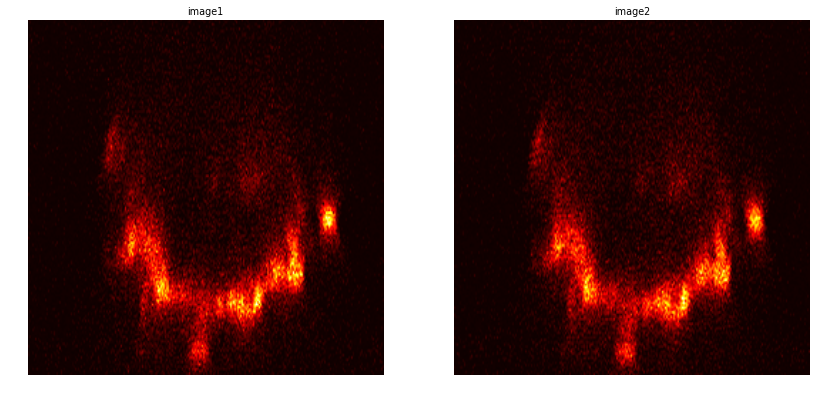

In [127]:
image_xz = Image(image[:,159,:], image.spacing[:-1])
image_xz = imops.zoom_to_isotropic_spacing(image_xz, order=2)

image_xz = imops.zero_pad_to_cube(image_xz)
image_xz = imops.crop_to_shape(image_xz, [500]*2)


image1_xz, image2_xz = imops.checkerboard_split(image_xz)


print image1_xz.spacing
#image = imops.zero_pad_to_cube(image)
display_2d_images(image1_xz, image2_xz)

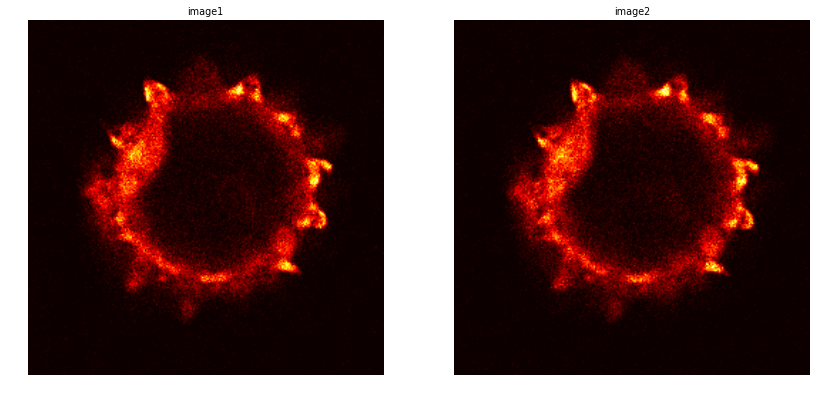

In [128]:
image_xy = Image(image[116], image.spacing[1:])
image_xy = imops.crop_to_shape(image_xy, [500]*2)


image1_xy, image2_xy = imops.checkerboard_split(image_xy)


display_2d_images(image1_xy, image2_xy)

In [129]:
data = FourierCorrelationDataCollection()

frc_task_xz = frc.FRC(image1_xz, image2_xz, args.d_bin)
data[90] = frc_task_xz.execute()

frc_task_xy = frc.FRC(image1_xy, image2_xy, args.d_bin)
data[0] = frc_task_xy.execute()
#display_2d_images(image1, image2)


In [130]:
analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1_xy.spacing[0], args)
results = analyzer.execute(z_correction=z_correction)

Fit starts at 0.239999994636
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.384000003338
Optimization terminated successfully.
         Current function value: 0.000157
         Iterations: 11
         Function evaluations: 22


## Results

The results look correct, but I am not sure about the numerical values, as I don't know the NA exactly.

$r_{xy} =  \frac{ 0.6 \lambda}{{NA}}$

$r_{z} = \frac{1.4 \lambda \eta}{{NA}^2} $

I'm going to confirm manually by line profile measurements.

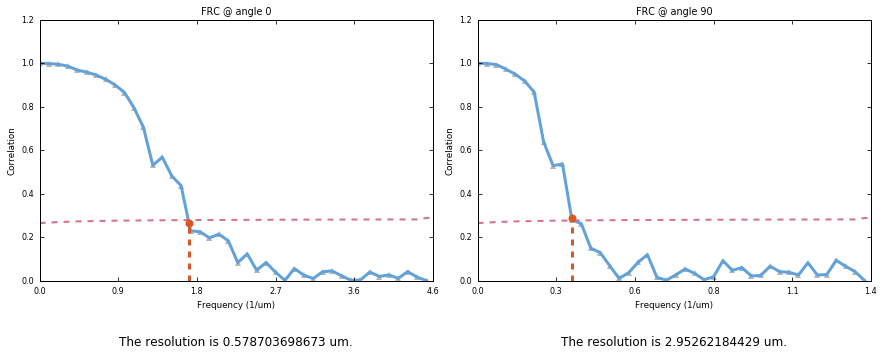

In [131]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()